# Image classifier

Предсказание пола, расы и возраста человека по его фотографии.

Все картинки приведены к одному размеру и лица находятся в центре изображения.
Воспользуемся **transfer learning и finetuning**. Т.е. взять за основу сеть, обученную на большом количестве данных для другой задачи и дообучить ее для текущей задачи.

Возьмем за основу сеть, которая была обучена на датасете [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/) для классификации лиц. Он содержит 3.3 миллиона изображений с 9000 разными персоналиями. Раз уж картинок больше чем персоналий, то можно предположить что к датасету была применена аугментация, а это снижает переобучаемость модели.

## Загрузка обученной модели

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
allow_growth = True

In [ ]:
! pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO'
output = 'resnet50face.h5'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO
To: /content/resnet50face.h5
166MB [00:03, 53.4MB/s]


'resnet50face.h5'

In [ ]:
from tensorflow.keras.models import load_model
vggface_model = load_model("resnet50face.h5")

In [ ]:
vggface_model.summary() # последний слой классифицирует на 8631 классов

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

Для проверки того, что помимо архитектуры веса были загруженны правильно, проверим предсказания модели на следующем изображении:

In [ ]:
! wget https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg -O brad_pitt.jpg

--2021-02-23 11:54:16--  https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.ua (img.joinfo.ua)... 172.67.214.206, 104.21.83.52, 2606:4700:3035::ac43:d6ce, ...
Connecting to img.joinfo.ua (img.joinfo.ua)|172.67.214.206|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.joinfo.com/i/2019/01/5c4ea940d2b08.jpg [following]
--2021-02-23 11:54:16--  https://img.joinfo.com/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.com (img.joinfo.com)... 172.67.188.219, 104.21.8.251, 2606:4700:3035::ac43:bcdb, ...
Connecting to img.joinfo.com (img.joinfo.com)|172.67.188.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43154 (42K) [image/jpeg]
Saving to: ‘brad_pitt.jpg’

brad_pitt.jpg       100%[===================>]  42.14K  --.-KB/s    in 0.004s  

2021-02-23 11:54:16 (11.6 MB/s) - ‘brad_pitt.jpg’ saved [43154/43154]



После загрузки запустим полный пример из репозитория:

1351680/1346516 [==============================] - 0s 0us/step


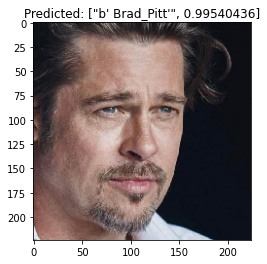

In [ ]:
from keras_vggface import utils
from tensorflow.keras.preprocessing import image

img = image.load_img("brad_pitt.jpg", target_size=(224, 224)) # модель работает с картинками размера 224 на 224
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) # мы используем resnet50 -- поэтому version2

preds = vggface_model.predict(x) 
plt.title(f"Predicted: {utils.decode_predictions(preds)[0][0]}") # используем decode_predictions из keras_vggface
plt.imshow(img)

## Загрузка данных

In [ ]:
from pathlib import Path
from collections import Counter

In [ ]:
url = 'https://drive.google.com/...'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/
url = 'https://drive.google.com/...'
output = 'train_val_split_utk.csv'
gdown.download(url, output, quiet=False)

In [ ]:
data_folder = Path("/tmp/UTKFace/")
# возвращение списка (возможно, пустой) путей, соответствующих шаблону pathname
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))  
print(len(filenames))
print(filenames[:3]) # имя файла содержит возраст, индекс пола и расы, перечисленные через нижнее подчеркивание

23708
['34_0_3_20170119200820917.jpg.chip.jpg', '33_0_3_20170117134831656.jpg.chip.jpg', '36_1_1_20170116153744623.jpg.chip.jpg']


In [ ]:
# формирование датафрейма с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 61_1_20170109150557335.jpg.chip.jpg
Bad filename 61_1_20170109142408075.jpg.chip.jpg
Bad filename 39_1_20170116174525125.jpg.chip.jpg


,img_name,age,race,gender
0,58_0_3_20170119211659305.jpg.chip.jpg,0.500000,3,0
1,58_0_0_20170120224629472.jpg.chip.jpg,0.500000,0,0
2,32_1_0_20170103181503793.jpg.chip.jpg,0.275862,0,1
3,22_1_2_20170116172549492.jpg.chip.jpg,0.189655,2,1
4,32_1_0_20170104165907161.jpg.chip.jpg,0.275862,0,1


In [ ]:
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))

4759 18946


In [ ]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   img_name  23705 non-null  object 
 1   age       23705 non-null  float32
 2   race      23705 non-null  object 
 3   gender    23705 non-null  object 
 4   is_train  23705 non-null  int64  
dtypes: float32(1), int64(1), object(3)
memory usage: 833.5+ KB


In [ ]:
df_split.head()

,is_train
img_name,
29_0_0_20170117180855986.jpg.chip.jpg,1
29_0_4_20170117202712541.jpg.chip.jpg,1
35_0_1_20170117104607288.jpg.chip.jpg,1
17_0_0_20170110231830374.jpg.chip.jpg,1
23_0_0_20170117194023317.jpg.chip.jpg,1


Проверка корректности меток классов:

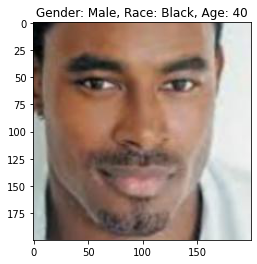

In [ ]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

Их распределение:

Counter({'White': 10078, 'Black': 4526, 'Indian': 3975, 'Asian': 3434, 'Others': 1692})
Counter({'Male': 12391, 'Female': 11314})


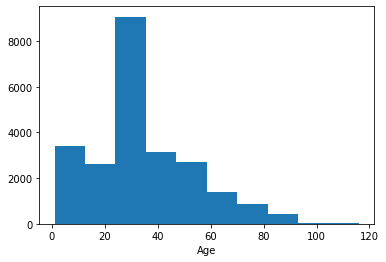

In [ ]:
races_verbose = [race_mapping[int(race)] for race in df["race"]]
genders_verbose = [gender_mapping[int(gender)] for gender in df["gender"]]
from collections import Counter
print(Counter(races_verbose))
print(Counter(genders_verbose))
_ = plt.hist(df["age"]*max_age)
_ = plt.xlabel("Age")

## Создание генератора данных для модели предсказания пола.

Создание генератора image_gen типа ImageDataGenerator с корректным препроцессингом, соответствующем keras_vggface.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_input_facenet(image_):
    """
    image_ -- тензор размера (1, H, W, 3)
    
    return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface (см пример с Бредом Питом)
    """
    preprocessed = image.img_to_array(image_)
    preprocessed = np.expand_dims(preprocessed, axis=0)
    preprocessed = utils.preprocess_input(preprocessed, version=2)
    
    return preprocessed

# https://overcoder.net/q/684981/%D1%86%D0%B5%D0%BB%D1%8C-%D0%B2%D1%8B%D0%B7%D0%BE%D0%B2%D0%B0-%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8-%D0%B1%D0%B5%D0%B7-%D1%81%D0%BA%D0%BE%D0%B1%D0%BE%D0%BA-python
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)  


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 128
IMAGE_SIZE = 224

train_generator = image_gen.flow_from_dataframe(dataframe=df_train, 
                                                directory=str(data_folder),
                                                x_col="img_name",
                                                y_col="gender",
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                batch_size=BATCH_SIZE,
                                                class_mode='binary',
                                                shuffle=True)                                       

val_generator = image_gen.flow_from_dataframe(dataframe=df_val,
                                              directory=str(data_folder),
                                              x_col="img_name",
                                              y_col="gender",
                                              target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                              batch_size=BATCH_SIZE,
                                              class_mode='binary',
                                              shuffle=False)

Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.


О
тображение картинки и её лейбла для проверки генерации:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Female


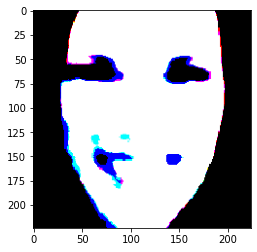

In [ ]:
plt.imshow(sample_images[100])
print(gender_mapping[int(sample_labels[100])])

In [ ]:
print(sample_images[100].max(), sample_images[100].min()) # можно увидеть что значения яркостей типа float и в т.ч. отрицательные

123.9088 -120.0912


Реализация функции `deprocess_image`, которая преобразует картинку используемой keras_vggface обратно к изображению, которое можно визуализировать с помощью `matplotlib`.
*  https://github.com/rcmalli/keras-vggface/blob/master/keras_vggface/utils.py
*  необходимо проделать операции preprocess_input в обратном порядке
*  наш случай: version=2, format="channels_last"

Female


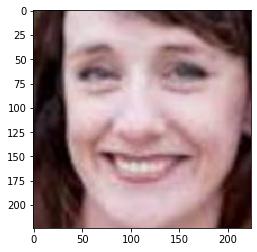

In [ ]:
def deprocess_image(vggface_image):
    """
    vggface_image -- (H, W, 3) картинка после препросессинга. 
    содержит отрицательные значения и некорректно отображается matplotlib
    return: корректно отображаеая 

    """
    
    image = np.copy(vggface_image)
    
    image[..., 2] += 131.0912
    image[..., 1] += 103.8827
    image[..., 0] += 91.4953
    image = image[..., ::-1] / 255
    
    return image

# теперь картинка должна отображаться корректно
plt.imshow(deprocess_image(sample_images[5]))
print(gender_mapping[int(sample_labels[5])])

### Обучение модели предсказания пола

In [ ]:
# для начала "отрежем" от vggface_model последний слой классификатора 
# теперь для картинки base_model предсказывает 2048-мерный вектор признаков.

base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False
base_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

In [ ]:
base_model.trainable = True
print("Количество слоев в базовой модели: ", len(base_model.layers))

Количество слоев в базовой модели:  175


In [ ]:
fine_tune_at = 100
# все слои до -- заморозить
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
from livelossplot.inputs.tf_keras import PlotLossesCallback

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 2048)              23561152  
_________________________________________________________________
dense_10 (Dense)             (None, 128)               262272    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 23,823,553
Trainable params: 9,191,681
Non-trainable params: 14,631,872
_________________________________________________________________


In [ ]:
path = Path("...")
path.mkdir(exist_ok=True, parents=True) # папка создается на диске вместе с "родителями"
assert path.exists()
cpt_filename = "checkpoint_best_gender.h5"
cpt_path = str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

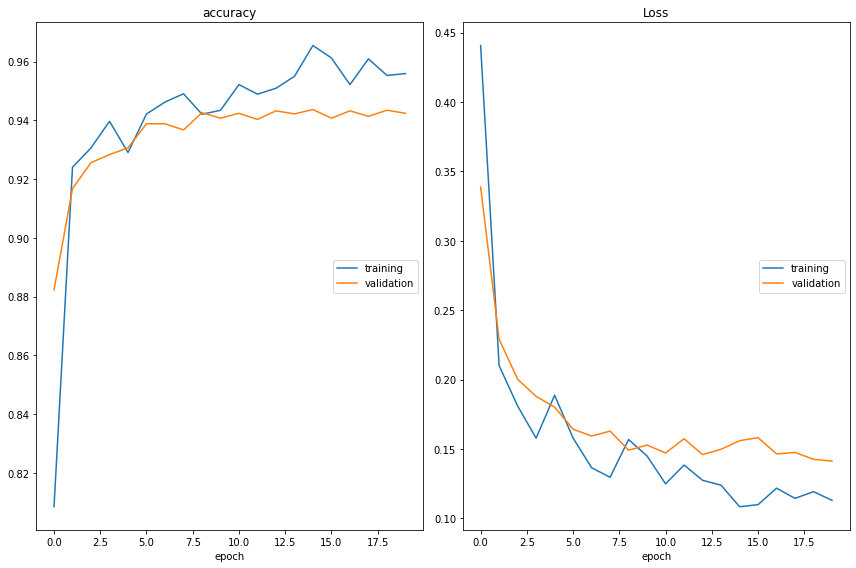

accuracy
	training         	 (min:    0.808, max:    0.966, cur:    0.956)
	validation       	 (min:    0.882, max:    0.944, cur:    0.942)
Loss
	training         	 (min:    0.108, max:    0.441, cur:    0.113)
	validation       	 (min:    0.141, max:    0.339, cur:    0.141)


In [ ]:
EPOCHS = 20
STEPS_PER_EPOCH = 25
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_generator,
    callbacks=[PlotLossesCallback(), checkpoint])

In [ ]:
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')
        

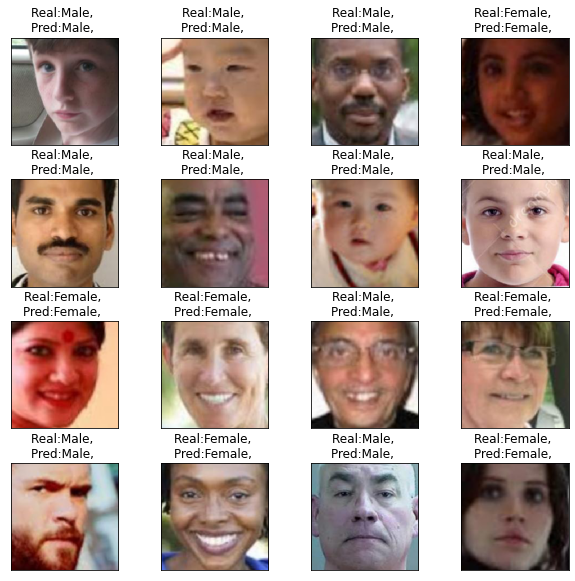

In [ ]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_gender.predict(sample_validation_images)
show_faces(sample_validation_images, real_gender=sample_validation_labels, predicted_gender=predicted)

##  Обучение модели предсказания расы

In [ ]:
BATCH_SIZE = 128
IMAGE_SIZE = 224

train_generator = image_gen.flow_from_dataframe(dataframe=df_train, 
                                                directory=str(data_folder),
                                                x_col="img_name",
                                                y_col="race",
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                batch_size=BATCH_SIZE,
                                                class_mode="sparse",
                                                shuffle=True)                                       

val_generator = image_gen.flow_from_dataframe(dataframe=df_val,
                                              directory=str(data_folder),
                                              x_col="img_name",
                                              y_col="race",
                                              target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                              batch_size=BATCH_SIZE,
                                              class_mode="sparse",
                                              shuffle=False)

Found 18946 validated image filenames belonging to 5 classes.
Found 4759 validated image filenames belonging to 5 classes.


In [ ]:
base_model.trainable = True
print("Количество слоев в базовой модели: ", len(base_model.layers))

fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Количество слоев в базовой модели:  175


In [ ]:
model_race = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])
model_race.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 2048)              23561152  
_________________________________________________________________
dense_14 (Dense)             (None, 64)                131136    
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 325       
Total params: 23,692,613
Trainable params: 19,564,933
Non-trainable params: 4,127,680
_________________________________________________________________


In [ ]:
path = Path("model_race")
path.mkdir(exist_ok=True, parents=True)
assert path.exists()
cpt_filename = "checkpoint_best_race.h5"
cpt_path = str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

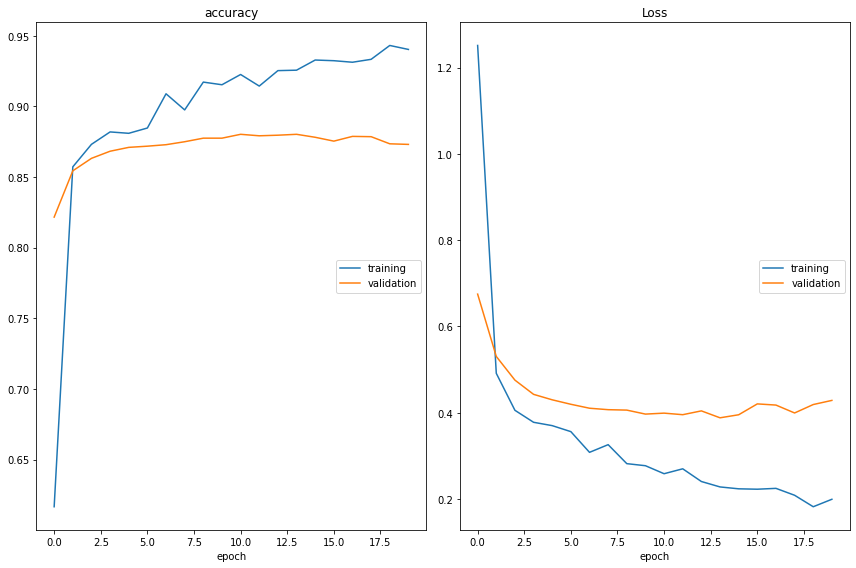

accuracy
	training         	 (min:    0.617, max:    0.943, cur:    0.940)
	validation       	 (min:    0.822, max:    0.880, cur:    0.873)
Loss
	training         	 (min:    0.182, max:    1.251, cur:    0.199)
	validation       	 (min:    0.388, max:    0.675, cur:    0.429)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model_race.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 20
STEPS_PER_EPOCH = 25
history = model_race.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_generator,
    callbacks=[PlotLossesCallback(), checkpoint])

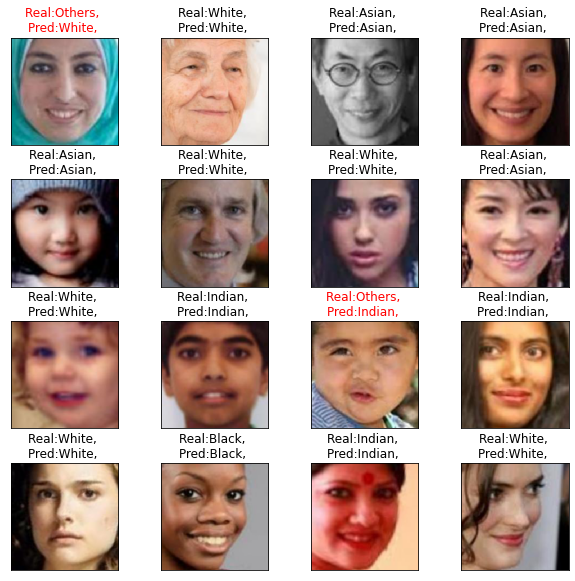

In [ ]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_race.predict(sample_validation_images)
show_faces(sample_validation_images, real_race=sample_validation_labels, predicted_race=predicted)

## Multitask learning

Необходимо вместо одной "головы" для предсказания сделать несколько. Таким образом этой в задаче одна будет отвечать за классификацию пола (1 выход, вероятность), вторая -- за классификацию расы (5 выходов, вероятности) и третья -- за предсказания возраста (1 выход, число).

In [ ]:
vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)

In [ ]:
base_model.trainable = True
print("Количество слоев в базовой модели: ", len(base_model.layers))

fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Количество слоев в базовой модели:  175


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_3 (Functional)            (None, 2048)         23561152    input_5[0][0]                    
__________________________________________________________________________________________________
gender_output_1 (Dense)         (None, 64)           131136      model_3[3][0]                    
__________________________________________________________________________________________________
race_output_1 (Dense)           (None, 64)           131136      model_3[3][0]                    
____________________________________________________________________________________________

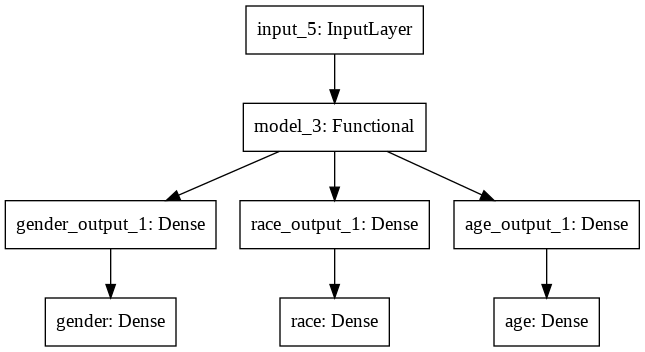

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense

input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

vggface_layer = base_model(input_layer)

# Полносвязная сеть для оперделения пола
gender_output = Dense(64, activation='relu', name="gender_output_1")(vggface_layer)
gender_output = Dense(1, activation='sigmoid', name="gender")(gender_output)

# Полносвязная сеть для оперделения расы
race_output = Dense(64, activation='relu', name="race_output_1")(vggface_layer)
race_output = Dense(5, activation='softmax', name="race")(race_output)

# Полносвязная сеть для определения возраста
age_output = Dense(64, activation='relu', name="age_output_1")(vggface_layer)
age_output = Dense(1, name="age")(age_output)

model = tf.keras.Model(inputs=input_layer, outputs=[gender_output, race_output, age_output])

model.summary()
plot_model(model)


In [ ]:
prediction = model(np.zeros((6, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32))
assert len(prediction) == 3, "Модель должна возвращать три тензора"
assert prediction[0].shape == (6, 1), f"Неправильный размер выхода gender: {prediction[0].shape}"
assert prediction[1].shape == (6, 5), f"Неправильный размер выхода race: {prediction[1].shape}"
assert prediction[2].shape == (6, 1), f"Неправильный размер выхода age: {prediction[2].shape}"
print("Shape tests passed")

Shape tests passed


Ниже мы приводим необходимые генераторы данных. Обратите внимание на y_col и class_mode.


In [ ]:
train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], # нас интересуют все три столбца
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=False)

Found 18946 validated image filenames.
Found 4759 validated image filenames.


In [ ]:
def split_outputs(generator):
    """
    Вспомогательная функция, которая модернизирует генераторы картинок, чтобы их
    можно было использовать для Мultitask
    image_gen.flow_from_dataframe возвращает на каждой итерации батч:
    ((N, H, W, 3), (N, 3)) -- N картинок и N троек меток (для трех "задач")
    model.fit(..) ожидает генератор в формате:
    ((N, H, W, 3), [(N, 1), (N, 1), (N, 1)])

    Для такого превращения и нужна эта функция.

    """
    while True:
        data = next(generator)
        image = data[0]
        labels = np.asarray(np.split(data[1], 3, axis=1)).astype(np.float32)
        yield image, [labels[0].astype(np.float32),
                      labels[1].astype(np.float32),
                      labels[2].astype(np.float32)]

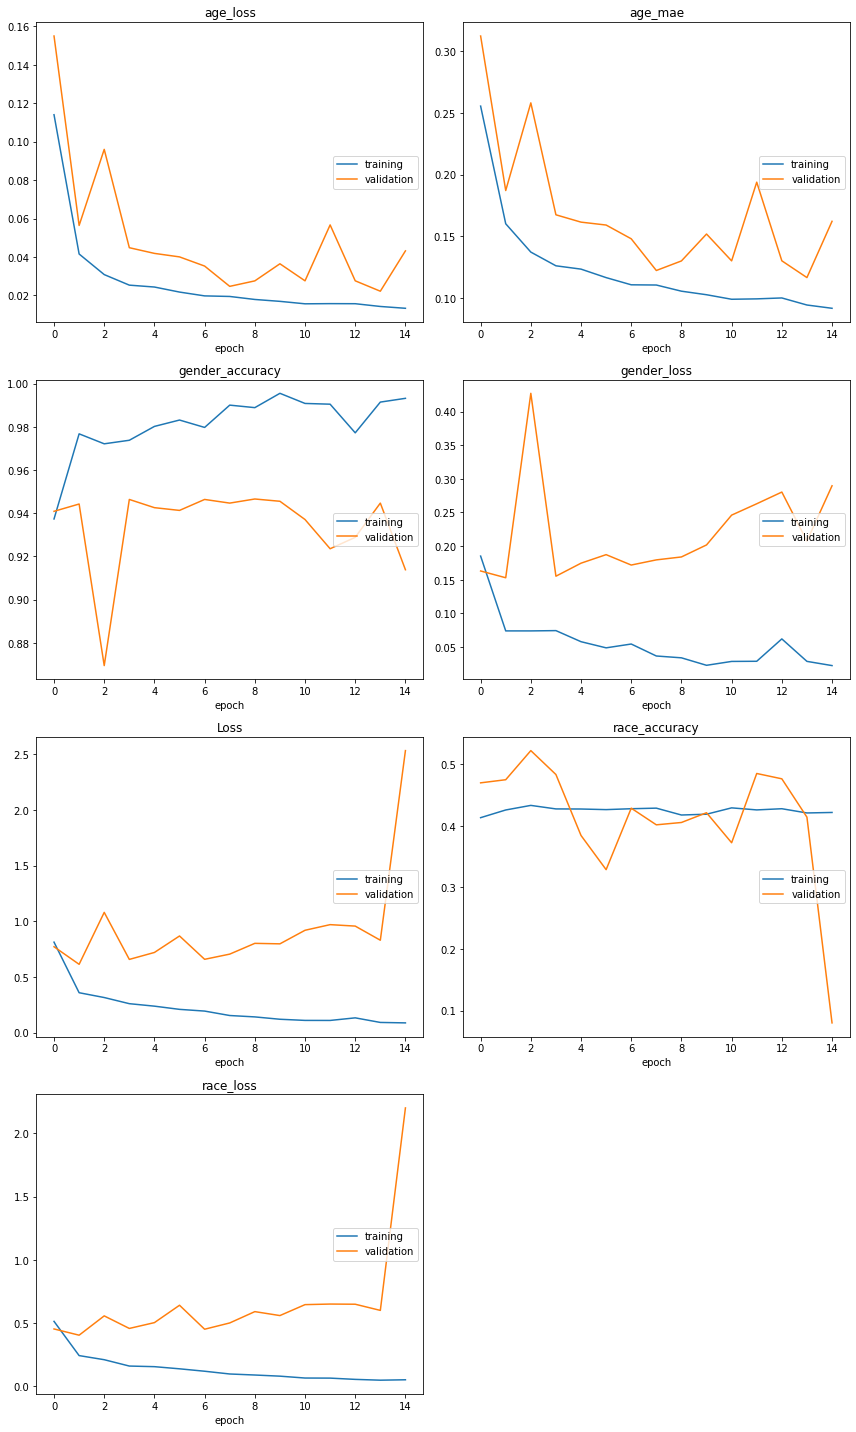

age_loss
	training         	 (min:    0.013, max:    0.114, cur:    0.013)
	validation       	 (min:    0.022, max:    0.155, cur:    0.043)
age_mae
	training         	 (min:    0.092, max:    0.255, cur:    0.092)
	validation       	 (min:    0.117, max:    0.312, cur:    0.162)
gender_accuracy
	training         	 (min:    0.937, max:    0.995, cur:    0.993)
	validation       	 (min:    0.870, max:    0.947, cur:    0.914)
gender_loss
	training         	 (min:    0.022, max:    0.185, cur:    0.022)
	validation       	 (min:    0.153, max:    0.427, cur:    0.290)
Loss
	training         	 (min:    0.088, max:    0.813, cur:    0.088)
	validation       	 (min:    0.614, max:    2.534, cur:    2.534)
race_accuracy
	training         	 (min:    0.413, max:    0.433, cur:    0.422)
	validation       	 (min:    0.080, max:    0.522, cur:    0.080)
race_loss
	training         	 (min:    0.049, max:    0.514, cur:    0.052)
	validation       	 (min:    0.405, max:    2.201, cur:    2.201)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, 
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              metrics={'gender': 'accuracy', 'race': 'accuracy', 'age': 'mae'})

path = Path("model_multitask")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.h5"
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_age_mae', verbose=0, save_best_only=True, mode='min')

model.fit(split_outputs(train_generator), epochs=15, validation_data=split_outputs(val_generator),
                    callbacks=[PlotLossesCallback(), checkpoint], steps_per_epoch=50, 
                    validation_steps=len(df_val) // BATCH_SIZE, verbose=1)

In [ ]:
# Проверка точности вручную

sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_multitask.predict(sample_validation_images)

list_labels = []
for i in range(len(sample_validation_labels)):
    list_labels.append(int(sample_validation_labels[i][1]))
array_labels = np.array(list_labels)

list_predictions = []
for i in range(len(predicted[1])):
    predicted_race = np.argmax(predicted[1][i])
    list_predictions.append(predicted_race)
array_predictions = np.array(list_predictions)

precision = (1-sum(array_labels != array_predictions)/len(predicted[1]))*100
precision

89.0625

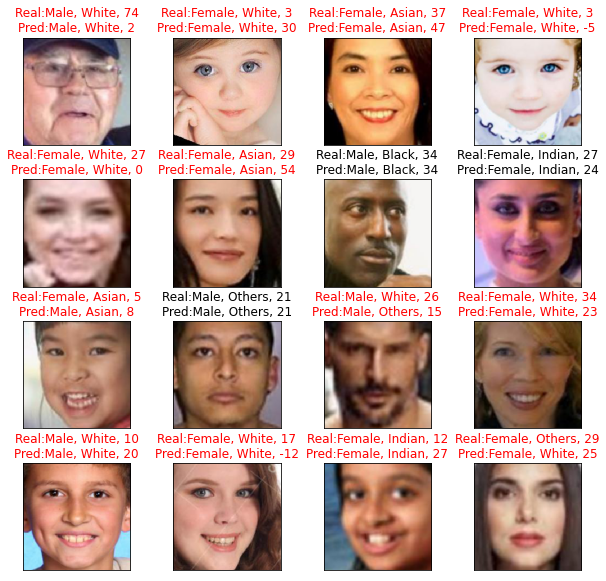

In [ ]:
sample_validation_images, sample_validation_labels = next(split_outputs(val_generator))
predicted = model_multitask.predict(sample_validation_images)
show_faces(sample_validation_images,
           real_gender=sample_validation_labels[0], predicted_gender=predicted[0],
           real_race=sample_validation_labels[1], predicted_race=predicted[1],
           real_age=sample_validation_labels[2].flatten(), predicted_age=predicted[2].flatten(),
           )